In [1]:
#install.packages("MLmetrics")
#install.packages("randomForest")

In [2]:
library(data.table)
library(tidyverse)
library(caret)
library(MLmetrics)
library(pROC)
library(randomForest)
library(doParallel)
options(scipen = 999)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks base::%||%()
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::qua

In [3]:
# Function to train model
train_model <- function(train_data, val_data, down_sample = FALSE, pre_process = NULL) {
  # Setting up train control
  train_control <- if (down_sample) {
    trainControl(method = "repeatedcv",
                 number = 10,
                 repeats = 5,
                 savePredictions = "final",
                 sampling = "down",
                 classProbs = TRUE,
                 summaryFunction = multiClassSummary)
  } else {
    trainControl(method = "repeatedcv",
                 number = 10,
                 repeats = 5,
                 savePredictions = "final",
                 classProbs = TRUE,
                 summaryFunction = multiClassSummary)
  }
  
  # Determine the number of predictors and the mtry range
  total_predictors <- ncol(train_data) - 1
  max_mtry <- min(total_predictors, sqrt(total_predictors) * 2)
  grid <- expand.grid(mtry = seq(2, max_mtry, by = 1))
  
  # Parallel processing setup
  cl <- makeCluster(6)
  registerDoParallel(cl)
  
  # Model training
  set.seed(757)
  model <- train(cohort ~ .,
                 data = train_data,
                 preProcess = pre_process,
                 method = "rf",
                 trControl = train_control,
                 tuneGrid = grid,
                 family = "multinomial",
                 importance = TRUE)
  
  # Stop parallel processing
  stopCluster(cl)
  
  return(model)
}

# Function to plot ROC curves
plot_roc_curves <- function(model, val_data, main = "ROC Curves for Each Class") {
  # Generate test predictions
  val_predictions <- predict(model, val_data, type = "prob")

  # Generate ROC curves
  roc_list <- list()
  auc_values <- c()
  for (class in levels(val_data$cohort)) {
    binary_response <- ifelse(val_data$cohort == class, class, "Other")
    binary_response <- factor(binary_response, levels = c("Other", class))
    roc_obj <- roc(response = binary_response, predictor = val_predictions[, class])
    roc_list[[class]] <- roc_obj
    auc_values[class] <- auc(roc_obj)
  }

  # Calculate average AUC
  average_auc <- mean(auc_values)

  # Plot combined ROC curves
  plot(roc_list[[1]], col = 1, main = main, print.auc = FALSE, legacy.axes = TRUE)
  for (i in 2:length(roc_list)) {
    plot(roc_list[[i]], col = i, add = TRUE, print.auc = FALSE, legacy.axes = TRUE)
  }

  # Create legend with AUC values and average AUC
  legend_text <- c(paste("Average AUC:", round(average_auc, 3)),
                   paste0(names(roc_list), " (AUC ", round(auc_values, 3), ")"))

  legend("bottomright", legend = legend_text, col = c(NA, 1:length(roc_list)), lwd = 2, 
         lty = c(NA, rep(1, length(roc_list))))
}

# Function to create confusion matrix
create_confusion_matrix <- function(model, val_data) {
  # Generate class predictions
  val_predictions_class <- predict(model, val_data)

  # Create confusion matrix
  confusion <- confusionMatrix(val_predictions_class, val_data$cohort)
  print(confusion)
}

# Function to calculate variable importance
calculate_variable_importance <- function(model) {
  # Calculate variable importance
  var_importance <- varImp(model, scale = FALSE)
  print(var_importance)
}

custom_preprocess <- function(train_data, test_data) {
  pca_data_train <- train_data[, pca_predictors]
  pca_data_test <- test_data[, pca_predictors]
  non_pca_data_train <- train_data[, non_pca_predictors]
  non_pca_data_test <- test_data[, non_pca_predictors]
  
  pca_data_train <- scale(pca_data_train)
  pca_data_test <- scale(pca_data_test, 
                         center = attr(pca_data_train, "scaled:center"), 
                         scale = attr(pca_data_train, "scaled:scale"))
  
  preProc <- preProcess(pca_data_train, method = c("center", "scale", "pca"), thresh = 0.9)
  pca_transformed_train <- predict(preProc, pca_data_train)
  pca_transformed_test <- predict(preProc, pca_data_test)
  
  non_pca_data_train <- scale(non_pca_data_train)
  non_pca_data_test <- scale(non_pca_data_test, 
                             center = attr(non_pca_data_train, "scaled:center"), 
                             scale = attr(non_pca_data_train, "scaled:scale"))
  
  combined_train <- cbind(pca_transformed_train, non_pca_data_train)
  combined_test <- cbind(pca_transformed_test, non_pca_data_test)
  
  combined_train <- data.frame(combined_train)
  combined_test <- data.frame(combined_test)
  
  combined_train$cohort <- train_data$cohort
  combined_test$cohort <- test_data$cohort
  
  return(list(train = combined_train, test = combined_test))
}

In [4]:
# Load data
libraries <- read_tsv("libraries.tsv", show_col_types = F) %>% 
  select(-file, - library_type, - isolation_type)

cna <- read.csv("CNA_no_trim_low_1Mb.csv")

cna_wide <- cna %>% 
  pivot_wider(names_from = c(chr, start, end), values_from = logR_Copy_Number) %>% 
  right_join(libraries, by = "library") %>% 
  mutate(cohort = factor(cohort, levels = c("Healthy", "Bladder", "Prostate", "RCC"))) %>% 
  filter(serial == 0 | (serial == 1 & cohort == "RCC")) %>%
  filter(duplicate == 0 | (duplicate ==  1 & batch != 1)) %>%
  select(-c(serial, duplicate, batch)) %>% 
  column_to_rownames("library") %>% 
  select(where(~ all(is.finite(.x))))

head(cna_wide)

arm_z <- read_tsv("arm_z.tsv")

arm_z_wide <- arm_z %>%
  right_join(libraries, by = "library") %>%
  filter(serial == 0 | (serial == 1 & cohort == "RCC")) %>%
  filter(duplicate == 0 | (duplicate ==  1 & batch != 1)) %>%
  select(-c(count, total, prop, serial, duplicate, batch)) %>%
  pivot_wider(names_from = c(chr, arm), values_from = z) %>%
  mutate(cohort = factor(cohort, levels = c("Healthy", "Bladder", "Prostate", "RCC"))) %>% 
  column_to_rownames("library")

head(arm_z_wide)

ratios <- read_tsv("ratios_150.tsv")

ratios_wide <- ratios %>% 
  right_join(libraries, by = "library") %>% 
  filter(serial == 0 | (serial == 1 & cohort == "RCC")) %>%
  filter(duplicate == 0 | (duplicate == 1 & batch != 1)) %>%
  select(-c(fract, serial, duplicate, batch)) %>% 
  pivot_wider(names_from = c(chr, start, end), values_from = ratio.centered) %>% 
  mutate(cohort = factor(cohort, levels = c("Healthy", "Bladder", "Prostate", "RCC"))) %>% 
  column_to_rownames("library")

head(ratios_wide)

,chr1_14000001_15000000,chr1_17000001_18000000,chr1_41000001_42000000,chr1_56000001_57000000,chr1_57000001_58000000,chr1_60000001_61000000,chr1_63000001_64000000,chr1_64000001_65000000,chr1_66000001_67000000,chr1_72000001_73000000,⋯,chr9_20000001_21000000,chr9_25000001_26000000,chr9_76000001_77000000,chr9_79000001_80000000,chr9_80000001_81000000,chr9_82000001_83000000,chr9_84000001_85000000,chr9_108000001_109000000,chr9_133000001_134000000,cohort
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
58,0.06167014,0.015625,0.015625,0.015625,0.0156250,0.4297331,0.0156250,1.7977810,2.063192,0.015625,⋯,2.261833,0.015625,0.0156250,0.0156250,0.1228652,0.01562500,0.2585802,0.01562500,0.015625,Healthy
73,2.45537999,0.015625,0.015625,0.015625,2.3609060,0.0156250,0.0156250,0.0156250,0.015625,0.015625,⋯,1.622996,0.015625,1.0154941,0.0156250,0.0156250,0.01562500,0.0156250,0.01562500,0.015625,Healthy
74,0.01562500,0.015625,0.015625,0.015625,0.0156250,0.0156250,0.0156250,0.0156250,0.015625,0.015625,⋯,0.015625,0.015625,0.0156250,0.0156250,0.0156250,0.01562500,0.0156250,0.01562500,0.015625,Healthy
81,0.01562500,0.015625,0.015625,0.015625,0.9211427,0.0156250,1.4294971,1.3750224,0.015625,0.015625,⋯,1.235997,0.015625,1.2056668,0.0156250,0.0156250,0.01562500,0.0156250,0.01562500,0.015625,Healthy
83,2.73354358,0.015625,0.015625,1.225360,0.0156250,1.6373099,0.6034994,2.8569948,1.984119,0.015625,⋯,2.806672,0.015625,0.9225598,0.8559575,1.0871419,0.04457905,0.2156928,0.27283363,0.015625,Healthy
BC001_UC1,2.63919856,0.015625,0.015625,0.015625,1.1304585,0.8683837,0.0156250,0.7393959,0.015625,0.015625,⋯,0.015625,0.015625,0.6593396,0.4172612,0.1455646,0.01562500,0.6964893,0.03007736,0.015625,Bladder


Rows: 9196 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): library, chr, arm
dbl (4): count, total, prop, z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,cohort,chr1_p,chr1_q,chr10_p,chr10_q,chr11_p,chr11_q,chr12_p,chr12_q,chr13_q,⋯,chr5_p,chr5_q,chr6_p,chr6_q,chr7_p,chr7_q,chr8_p,chr8_q,chr9_p,chr9_q
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,Healthy,0.50063823,0.48154809,-0.4109887,0.8488111,-0.2185774,0.8245766,0.64936915,-0.4054111,0.02929311,⋯,-0.2630702,-0.1914125,0.6096090,-0.4209649,-0.7868072,-0.33002522,-0.40274504,-0.7136317,-0.2842868,0.1083900
73,Healthy,-1.08342573,-1.22078356,0.4593645,0.3662289,1.6662930,-0.5844587,0.15218814,-0.7047062,0.64247480,⋯,1.4847444,-0.7568644,-1.0003825,1.0541553,0.4086525,1.29279721,0.07235497,0.7485823,0.8070863,0.2778310
74,Healthy,-0.42080347,0.05109919,1.1880644,-0.7640851,-0.5764970,-2.1386499,-0.09416214,-0.3532011,0.22007234,⋯,-0.1254664,0.6309591,0.6312291,0.1975579,0.1307842,-0.14653754,-0.37936542,0.1380852,0.1621911,-0.5780781
81,Healthy,-1.39899610,1.30864628,-0.7943028,0.7324163,3.0115885,1.9217973,-1.77014816,-0.8093310,0.32586097,⋯,1.9791306,-0.1898159,-2.5456314,1.8172323,1.2649739,2.24668682,1.56938656,1.5800917,0.3931571,0.3382786
83,Healthy,-0.03387995,0.63328717,-0.6785557,0.4353614,0.3832543,0.7200534,0.86860577,-0.3587962,0.11218346,⋯,0.9869821,2.0861880,0.6030338,0.2947142,0.6726830,0.05509950,-1.00593937,0.7453578,0.4682202,-0.3473265
BC001_UC1,Bladder,0.78027430,3.41768245,-2.5338192,-0.7874392,-2.3706222,-0.3701958,-0.91550725,-2.2527878,-1.33697258,⋯,0.8023584,-3.4861750,0.9641730,0.6603840,2.9982084,-0.07913414,-8.38971291,1.3952361,-1.7557358,-0.9220450


Rows: 75504 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): library, chr
dbl (4): start, end, fract, ratio.centered

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,cohort,chr1_5000000_10000000,chr1_10000000_15000000,chr1_15000000_20000000,chr1_20000000_25000000,chr1_25000000_30000000,chr1_30000000_35000000,chr1_35000000_40000000,chr1_40000000_45000000,chr1_45000000_50000000,⋯,chr9_15000000_20000000,chr9_20000000_25000000,chr9_25000000_30000000,chr9_90000000_95000000,chr9_95000000_100000000,chr9_100000000_105000000,chr9_110000000_115000000,chr9_115000000_120000000,chr9_120000000_125000000,chr9_125000000_130000000
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,Healthy,-0.021039193,-0.019367409,-0.030352882,-0.020653719,-0.020983022,-0.011687578,-0.010892757,-0.02011605,-0.01449747793,⋯,0.007121641,0.015005933,0.011724598,-0.0096846841,-0.01706410,0.015935996,-0.017214138,0.002501476,-0.0127676908,-0.025227747
73,Healthy,0.051770455,0.024913960,0.036842265,0.059738798,0.026991958,0.059262710,0.024624447,0.04253434,0.01022139777,⋯,-0.012613209,-0.033647916,-0.036388495,0.0384463680,-0.00784013,-0.057903816,0.039414865,0.014236239,-0.0003444574,0.032790556
74,Healthy,0.035061812,0.033906632,0.021390122,0.031846494,0.014884736,0.024984771,0.018009406,0.01743073,-0.00948206470,⋯,0.004667940,-0.021090794,-0.019005047,-0.0056668984,0.01070164,-0.020067176,0.003183315,0.008317238,0.0141085827,0.023628447
81,Healthy,0.028886112,0.018559176,0.021572711,0.024239990,0.020357612,0.019593154,0.003842594,0.01211891,-0.00912732939,⋯,-0.009311245,0.001899749,-0.002606860,0.0146361584,-0.01313830,-0.011739251,0.010163005,-0.009430819,-0.0090226730,0.011813579
83,Healthy,-0.033047928,-0.037325415,-0.048438885,-0.041196328,-0.034454643,-0.029842160,-0.020518362,-0.02176761,-0.02295445300,⋯,0.006939916,0.017984556,0.019683129,-0.0179844822,-0.01173694,0.017108347,-0.017930186,0.009450506,-0.0192969461,-0.045385610
BC001_UC1,Bladder,0.001773252,0.005899454,0.001089814,0.004012813,0.009259055,0.001114408,0.003944155,0.00543029,0.00005627234,⋯,-0.001822032,-0.005369531,-0.001672892,0.0006187857,0.00275789,-0.004630155,0.006036741,-0.006101459,-0.0003221017,0.006258256


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Setting levels: control = Other, case = Healthy

Setting direction: controls < cases

Setting levels: control = Other, case = Bladder

Setting direction: controls < cases

Setting levels: control = Other, case = Prostate

Setting direction: controls < cases

Setting levels: control = Other, case = RCC

Setting direction: controls < cases



Confusion Matrix and Statistics

          Reference
Prediction Healthy Bladder Prostate RCC
  Healthy        5       2        1   0
  Bladder        3      17        3   2
  Prostate       0       7        6   1
  RCC            2       2        2   7

Overall Statistics
                                          
               Accuracy : 0.5833          
                 95% CI : (0.4488, 0.7093)
    No Information Rate : 0.4667          
    P-Value [Acc > NIR] : 0.04638         
                                          
                  Kappa : 0.4052          
                                          
 Mcnemar's Test P-Value : 0.52683         

Statistics by Class:

                     Class: Healthy Class: Bladder Class: Prostate Class: RCC
Sensitivity                 0.50000         0.6071          0.5000     0.7000
Specificity                 0.94000         0.7500          0.8333     0.8800
Pos Pred Value              0.62500         0.6800          0.4286     0.5385
Neg P

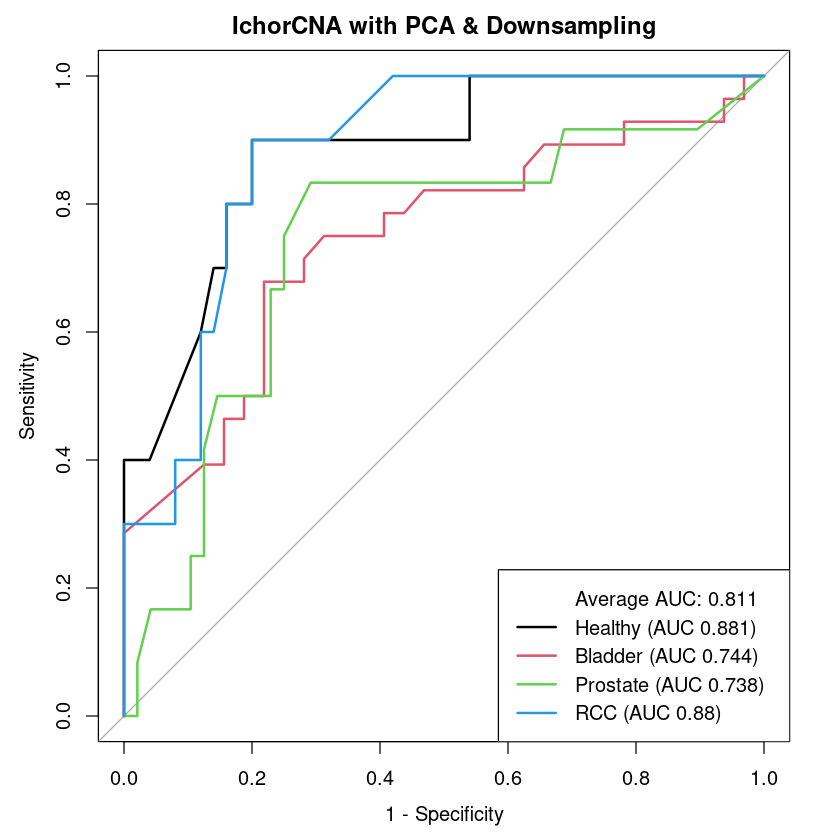

In [5]:
# CNA model - PCA on training data + downsampling to correct class imbalance
set.seed(757)

train_index_cna <- createDataPartition(cna_wide$cohort, p = 0.7, list = FALSE, times = 1)

train_data_cna <- cna_wide[train_index_cna,]
val_data_cna <- cna_wide[-train_index_cna,]

model_cna <- train_model(train_data_cna, val_data_cna, down_sample = TRUE, 
                         pre_process = c("center", "scale", "nzv", "pca"))

plot_roc_curves(model_cna, val_data_cna, main = "IchorCNA with PCA & Downsampling")

create_confusion_matrix(model_cna, val_data_cna)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Setting levels: control = Other, case = Healthy

Setting direction: controls < cases

Setting levels: control = Other, case = Bladder

Setting direction: controls < cases

Setting levels: control = Other, case = Prostate

Setting direction: controls < cases

Setting levels: control = Other, case = RCC

Setting direction: controls < cases



Confusion Matrix and Statistics

          Reference
Prediction Healthy Bladder Prostate RCC
  Healthy        4       1        1   2
  Bladder        4      25        6   3
  Prostate       1       0        3   3
  RCC            1       2        2   2

Overall Statistics
                                          
               Accuracy : 0.5667          
                 95% CI : (0.4324, 0.6941)
    No Information Rate : 0.4667          
    P-Value [Acc > NIR] : 0.07747         
                                          
                  Kappa : 0.3223          
                                          
 Mcnemar's Test P-Value : 0.20157         

Statistics by Class:

                     Class: Healthy Class: Bladder Class: Prostate Class: RCC
Sensitivity                 0.40000         0.8929          0.2500    0.20000
Specificity                 0.92000         0.5938          0.9167    0.90000
Pos Pred Value              0.50000         0.6579          0.4286    0.28571
Neg P

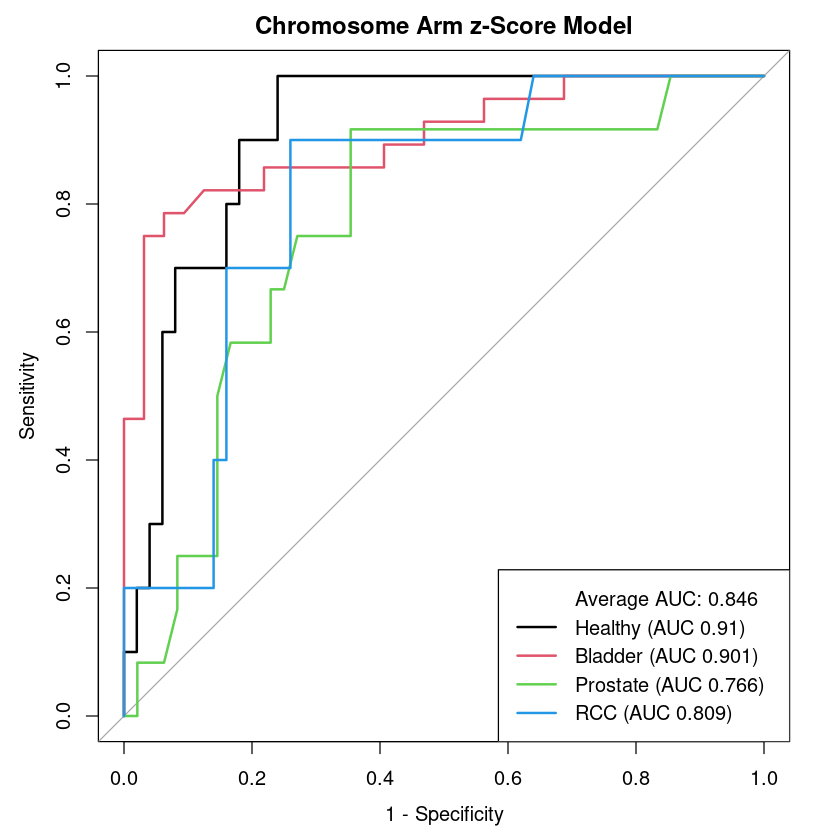

In [6]:
# Chromosome Arm z-score Model
set.seed(757)

train_index_armz <- createDataPartition(arm_z_wide$cohort, p = .7, list = FALSE, times = 1)

train_data_armz <- arm_z_wide[train_index_armz,]
val_data_armz <- arm_z_wide[-train_index_armz,]

model_armz <- train_model(train_data_armz, val_data_armz, down_sample = FALSE, 
                          pre_process = c("center", "scale", "nzv"))

plot_roc_curves(model_armz, val_data_armz, main = "Chromosome Arm z-Score Model")

create_confusion_matrix(model_armz, val_data_armz)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Setting levels: control = Other, case = Healthy

Setting direction: controls < cases

Setting levels: control = Other, case = Bladder

Setting direction: controls < cases

Setting levels: control = Other, case = Prostate

Setting direction: controls < cases

Setting levels: control = Other, case = RCC

Setting direction: controls < cases



Confusion Matrix and Statistics

          Reference
Prediction Healthy Bladder Prostate RCC
  Healthy        0       0        2   4
  Bladder        5      27        6   4
  Prostate       4       1        3   1
  RCC            1       0        1   1

Overall Statistics
                                          
               Accuracy : 0.5167          
                 95% CI : (0.3839, 0.6477)
    No Information Rate : 0.4667          
    P-Value [Acc > NIR] : 0.25846         
                                          
                  Kappa : 0.2183          
                                          
 Mcnemar's Test P-Value : 0.01996         

Statistics by Class:

                     Class: Healthy Class: Bladder Class: Prostate Class: RCC
Sensitivity                  0.0000         0.9643          0.2500    0.10000
Specificity                  0.8800         0.5312          0.8750    0.96000
Pos Pred Value               0.0000         0.6429          0.3333    0.33333
Neg P

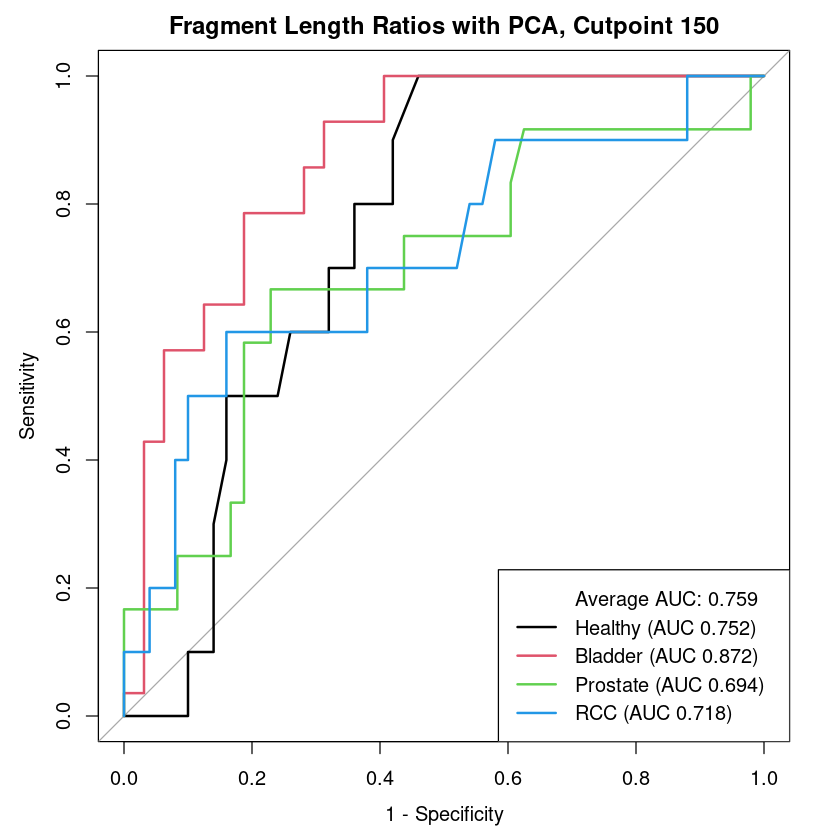

In [7]:
# Fragment Length Ratio Model - PCA on Training Data
set.seed(757)

train_index_ratios <- createDataPartition(ratios_wide$cohort, p = 0.7, list = FALSE, times = 1)

train_data_ratios <- ratios_wide[train_index_ratios,]
val_data_ratios <- ratios_wide[-train_index_ratios,]

model_ratios <- train_model(train_data_ratios, val_data_ratios, down_sample = FALSE, 
                            pre_process = c("center", "scale", "nzv", "pca"))

plot_roc_curves(model_ratios, val_data_ratios, main = "Fragment Length Ratios with PCA, Cutpoint 150")

create_confusion_matrix(model_ratios, val_data_ratios)

In [8]:
# Combined Fragment Length Ratio / Chromosome Arm z-Score Model
# Extract the pre-processed data for fragment length ratios and chromosome arm z-scores
preProcess_obj_armz <- model_armz$preProcess
preprocessed_train_data_armz <- predict(preProcess_obj_armz, train_data_armz) %>% 
  rownames_to_column("library")
preprocessed_val_data_armz <- predict(preProcess_obj_armz, val_data_armz) %>% 
  rownames_to_column("library")

preProcess_obj_ratios <- model_ratios$preProcess
preprocessed_train_data_ratios <- predict(preProcess_obj_ratios, train_data_ratios) %>% 
  rownames_to_column("library")
preprocessed_val_data_ratios <- predict(preProcess_obj_ratios, val_data_ratios) %>% 
  rownames_to_column("library")

# Join to make data frame for combined model
train_data_comb <- left_join(preprocessed_train_data_armz, preprocessed_train_data_ratios,
                             by = c("library", "cohort")) %>% 
  column_to_rownames("library")
val_data_comb <- left_join(preprocessed_val_data_armz, preprocessed_val_data_ratios,
                             by = c("library", "cohort")) %>% 
  column_to_rownames("library")

head(train_data_comb)
head(val_data_comb)

,cohort,chr1_p,chr1_q,chr10_p,chr10_q,chr11_p,chr11_q,chr12_p,chr12_q,chr13_q,⋯,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,Healthy,0.2664956,-0.14616793,-0.33729302,0.31541509,0.3118690,0.1642629778,0.03659493,-0.3441912,0.2220218,⋯,2.3618070,-1.4776915,0.04535213,-0.4283585,0.7363575,-0.80821645,0.83367291,-0.2932179,0.6259794,-0.07892941
73,Healthy,-0.5832017,-0.57035262,-0.17879439,0.25545024,0.6840869,0.0001956762,-0.17345909,-0.3973868,0.4904379,⋯,-8.7858076,0.7310273,7.27669335,3.7957962,8.0635903,3.41996305,-4.58104526,-0.5689758,0.5712995,1.48273684
74,Healthy,-0.2277689,-0.25342660,-0.04609201,0.11499935,0.2411882,-0.1807734966,-0.27753962,-0.3349116,0.3055341,⋯,0.8454248,0.3615468,-1.22793728,-2.1719313,-1.1871637,0.01991799,-0.99715419,-0.2792904,0.1840131,-0.66553615
81,Healthy,-0.7524747,0.05992728,-0.40709773,0.30095207,0.9497513,0.2920227676,-0.98562700,-0.4159824,0.3518424,⋯,-2.3846393,-0.6057797,3.47888614,2.2264250,3.6813948,-0.43569993,-2.33527075,-0.7529257,-0.2018131,-0.16450026
BC001_UC1,Bladder,0.4164933,0.58545407,-0.72387828,0.11209741,-0.1131097,0.0251443345,-0.62454974,-0.6725371,-0.3760518,⋯,1.4719840,0.8208586,-0.14977258,-0.5532263,0.4467387,-0.56746503,0.62418844,-0.3223844,-0.4288338,0.28794658
BC002_UC1,Bladder,-1.1716203,0.45739122,0.78919591,0.06411248,1.1719070,0.8425078920,0.08580198,-0.7750778,-0.5610751,⋯,0.6438417,0.6767820,-0.30414276,-0.6927217,0.7010755,-0.79539868,-0.03758274,-0.2662164,-0.7464683,-0.54789251


,cohort,chr1_p,chr1_q,chr10_p,chr10_q,chr11_p,chr11_q,chr12_p,chr12_q,chr13_q,⋯,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
83,Healthy,-0.02022181,-0.1083578,-0.38601921,0.26404054,0.4307167,0.15209235,0.1292202,-0.3359060,0.2583065,⋯,0.3801444,0.1779276,-0.2888056,-0.43167432,0.7381669,-0.75475834,0.6053232,0.08520617,0.6693784,-0.13940093
BC005_UC1,Bladder,-0.61028918,-0.3836993,-0.16991552,0.07408134,0.3324985,-0.02835693,0.1766977,-0.2029135,0.4749498,⋯,-2.7698426,0.2920952,0.3274881,0.42828866,-1.4619191,0.11091004,-0.5664183,1.46441738,0.6743065,-0.66883494
BC008_UC1,Bladder,-0.43745392,-0.1192812,0.51183204,-0.40213082,1.5385971,1.15131350,-1.1790841,-1.5607176,-1.0102871,⋯,-0.5115805,-1.6227881,-0.6575454,-0.08061064,1.8680152,-6.00272169,-3.2841387,3.22758895,-4.4368710,-2.52599654
BC017_UC1,Bladder,1.94299519,0.1225951,-1.15490534,-1.47025725,1.4732085,2.47178834,0.9540860,-0.6875719,0.6549732,⋯,1.0685622,0.3450175,-1.3560646,0.29664033,-0.1040018,-1.38447672,0.0990976,0.33335944,0.7043298,-0.08595036
BC018_UC1,Bladder,1.91395819,-5.7997709,-2.73538872,-8.42888599,-1.1871647,-2.17045827,-7.3077881,1.7943112,-5.0967574,⋯,-1.2290618,0.9644648,-0.9289736,-0.14296872,1.1377863,-1.44202766,-0.3789719,-0.17063272,-0.9166324,0.29428369
BC022_UC1,Bladder,-0.82819015,-0.1677119,0.08677039,0.02503353,0.5351404,-0.45333128,0.1205817,-0.2927649,1.1764130,⋯,1.6003450,1.1408981,1.6163013,-0.67110500,0.4454760,-0.09705156,1.4630315,-0.02579801,-0.2486643,0.91933818


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Setting levels: control = Other, case = Healthy

Setting direction: controls < cases

Setting levels: control = Other, case = Bladder

Setting direction: controls < cases

Setting levels: control = Other, case = Prostate

Setting direction: controls < cases

Setting levels: control = Other, case = RCC

Setting direction: controls < cases



Confusion Matrix and Statistics

          Reference
Prediction Healthy Bladder Prostate RCC
  Healthy        4       0        1   1
  Bladder        3      26        6   3
  Prostate       2       1        2   4
  RCC            1       1        3   2

Overall Statistics
                                          
               Accuracy : 0.5667          
                 95% CI : (0.4324, 0.6941)
    No Information Rate : 0.4667          
    P-Value [Acc > NIR] : 0.07747         
                                          
                  Kappa : 0.3211          
                                          
 Mcnemar's Test P-Value : 0.23464         

Statistics by Class:

                     Class: Healthy Class: Bladder Class: Prostate Class: RCC
Sensitivity                 0.40000         0.9286         0.16667    0.20000
Specificity                 0.96000         0.6250         0.85417    0.90000
Pos Pred Value              0.66667         0.6842         0.22222    0.28571
Neg P

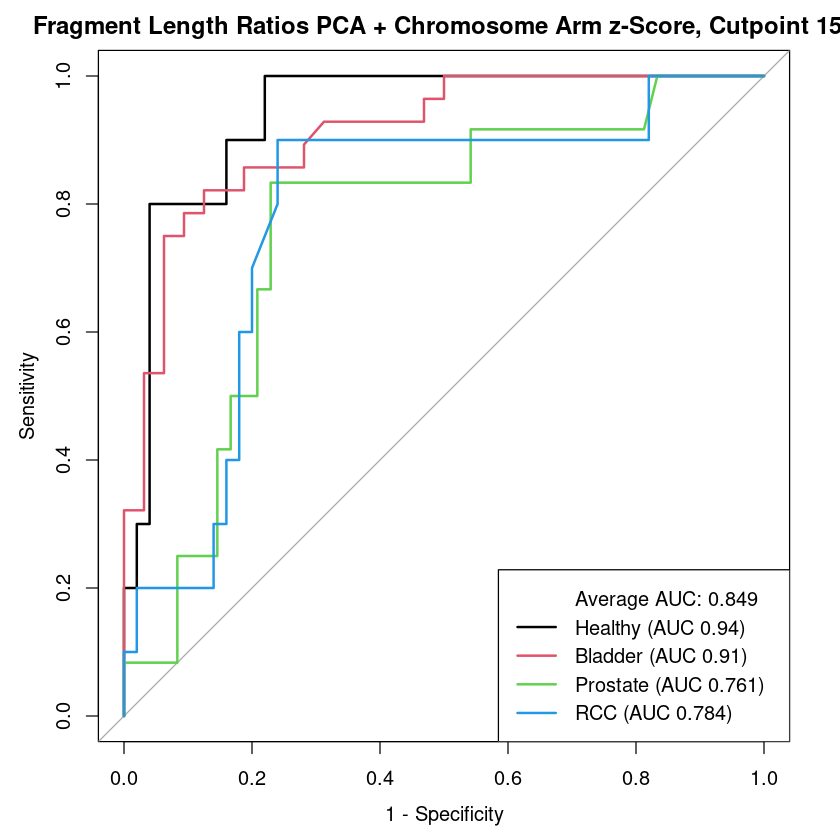

In [9]:
set.seed(757)

model_comb <- train_model(train_data_comb, val_data_comb, down_sample = FALSE, 
                         pre_process = NULL)

plot_roc_curves(model_comb, val_data_comb, main = "Fragment Length Ratios PCA + Chromosome Arm z-Score, Cutpoint 150")

create_confusion_matrix(model_comb, val_data_comb)